<table align="left">
  <td>
    <a href="https://tinyurl.com/2pkzxsha" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# CNN - Tensorflow - Multi-Class Image Classification

En este notebook se desarrollará un modelo para la clasificación de 10 clases de imagenes de comida. El dataset se encuentra disponible en Kaggle: https://www.kaggle.com/kmader/food41

Se seguirán los siguientes pasos:

1. Conocer el dataset
2. Preprocesar los datos - ajustarlos para el modelo
3. Construir el modelo (modelo base)
4. Entrenar el modelo (apuntar a alcanzar overfitting)
5. Evaluar el modelo
6. Ajustar hipermárametros y mejorar el modelo (vencer resultado base y reducir overfitting)
7. Repetir 4, 5 y 6 hasta alcanzar el resultado deseado

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## 1. Conocer el dataset

In [3]:
import zipfile
if(os.path.exists('10_food_classes_all_data')):
    print('Files exists')
else:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
    zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()

Files exists


In [4]:
# Explorar la carpeta con los datos
for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
    print(f'Hay {len(dirnames)} directorios y {len(filenames)} archivos en {dirpath}')

Hay 2 directorios y 0 archivos en 10_food_classes_all_data
Hay 10 directorios y 0 archivos en 10_food_classes_all_data\test
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\chicken_curry
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\chicken_wings
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\fried_rice
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\grilled_salmon
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\hamburger
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\ice_cream
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\pizza
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\ramen
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\steak
Hay 0 directorios y 250 archivos en 10_food_classes_all_data\test\sushi
Hay 10 directorios y 0 archivos en 10_food_classes_all_data\train
Hay 0 directorios y 750 archivos en 10_food_classes_

In [5]:
!dir 10_food_classes_all_data

 El volumen de la unidad H es Google Drive
 El n�mero de serie del volumen es: 1983-1116

 Directorio de h:\Mi unidad\Github\TensorFlow-Course\10_food_classes_all_data

24/12/2022  11:41 a. m.    <DIR>          .
24/12/2022  11:43 a. m.    <DIR>          ..
24/12/2022  11:40 a. m.    <DIR>          test
24/12/2022  11:49 a. m.    <DIR>          train
               0 archivos              0 bytes
               4 dirs  102.581.764.096 bytes libres


In [11]:
# Crear los paths para los directorios de entrenamiento y prueba
train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [12]:
# Obtener las clases de los directorios
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [10]:
# Visualizar las imagenes
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Set the target directory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (384, 512, 3)


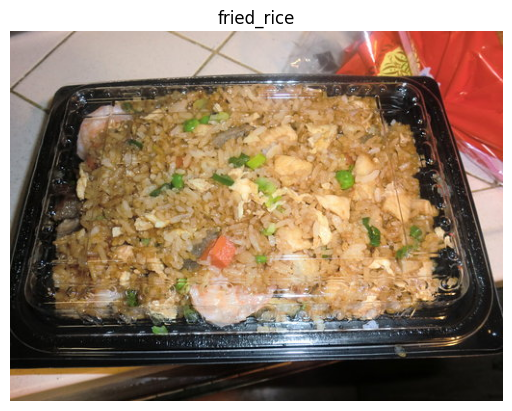

In [17]:
# Visualizar las imágenes de la carpeta de entrenamiento
img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names))

## 2. Preprocesar los datos - ajustarlos para el modelo

In [18]:
# ImageGenerator para entrenamiento y prueba
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear los ImageGenerator para entrenamiento y prueba
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Cargar los datos de entrenamiento y prueba desde los directorios en batches

train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                seed=42)                                                

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [20]:
# Obtener un ejemplo de un lote de imagenes y sus etiquetas
images, labels = train_data.next() # next() devuelve un lote de imagenes y sus etiquetas

len(images), len(labels)

(32, 32)

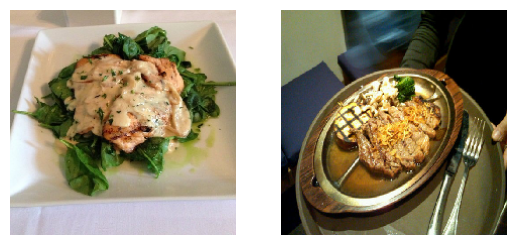

In [23]:
# Visualizar las dos primeras imagenes del lote
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(images[1])
plt.axis("Off");

In [22]:
# labels codificadas en one-hot
labels[:2]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## 3 - 4. Construir y Entrenar el modelo CNN

Construir un modelo CNN (Tiny VGG the CNN explainer website https://poloclub.github.io/cnn-explainer/)

In [24]:
# Construir un modelo CNN (Tiny VGG the CNN explainer website https://poloclub.github.io/cnn-explainer/)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),

    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")])

# Compilar el modelo
model_1.compile(loss="categorical_crossentropy", # labels codificadas en one-hot
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Entrenar el modelo
history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data), 
                        validation_data=test_data,
                        validation_steps=len(test_data), 
                        verbose=1)

Epoch 1/10
235/235 [==============================] - 93s 395ms/step - loss: 2.1289 - accuracy: 0.2228 - val_loss: 2.0462 - val_accuracy: 0.2644
Epoch 2/10
235/235 [==============================] - 95s 404ms/step - loss: 1.8768 - accuracy: 0.3473 - val_loss: 1.9158 - val_accuracy: 0.3376
Epoch 3/10
235/235 [==============================] - 92s 389ms/step - loss: 1.5626 - accuracy: 0.4728 - val_loss: 1.9251 - val_accuracy: 0.3416
Epoch 4/10
235/235 [==============================] - 92s 392ms/step - loss: 1.0165 - accuracy: 0.6695 - val_loss: 2.0931 - val_accuracy: 0.3104
Epoch 5/10
235/235 [==============================] - 91s 387ms/step - loss: 0.4566 - accuracy: 0.8639 - val_loss: 2.9930 - val_accuracy: 0.2764
Epoch 6/10
235/235 [==============================] - 95s 406ms/step - loss: 0.1618 - accuracy: 0.9591 - val_loss: 3.8231 - val_accuracy: 0.2848
Epoch 7/10
235/235 [==============================] - 94s 400ms/step - loss: 0.0503 - accuracy: 0.9897 - val_loss: 4.7807 - val_ac

## 5. Evaluar el modelo

In [25]:
def plot_training_curves(history):
    """
    Plot training curves for accuracy and loss
    - input: history object from model.fit()
    - output: plot of training curves
    """
    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Training Curves')
    plt.ylabel('Accuracy')
    #plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.grid(True)
    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.grid(True)
    plt.show()

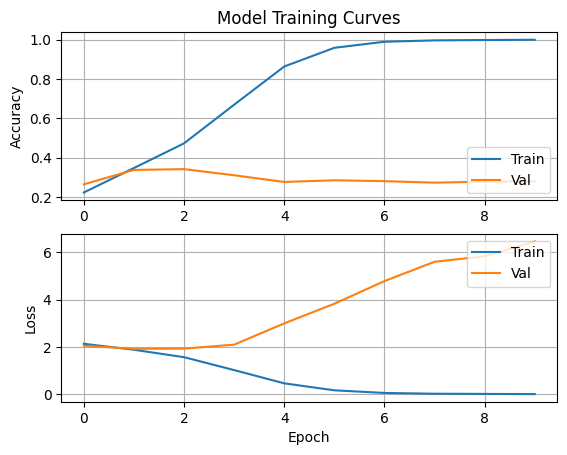

In [26]:
plot_training_curves(history_1)

> :eye: **Nota:** Los resultados de las curvas de entrenamiento muestran que el model_1 está sobreajustado. Esto se puede ver en la curva de pérdida de entrenamiento, que disminuye a medida que aumenta el número de épocas, mientras que la curva de pérdida de validación aumenta a medida que aumenta el número de épocas. Esto se debe a que el modelo no puede generalizar bien a los datos de validación. 

> - Para reducir el sobreajuste, se puede agregar regularización, aumentar el conjunto de datos de entrenamiento o reducir la complejidad del modelo.

## 6. Ajustar hipermárametros y mejorar el modelo

Entrenar un modelo de machine learning es un proceso iterativo que se puede dividir en los siguientes pasos:

1. Crear un modelo Base
2. Vencer el modelo Base sobreajustando un modelo mayor. 
3. Reducir el sobreajuste del modelo mayor.

**Formas de reducir el sobreajuste:**

* Agregar aumentación de datos
* Agregar capas de regularización (como Dropout, **MaxPooling2D**, etc.)
* Agregar mas datos de entrenamiento
* ...

In [27]:
# Data augmentation

# Crear el ImageGenerator para entrenamiento y prueba
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                            rotation_range=0.2,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                seed=42)

Found 7500 images belonging to 10 classes.


In [48]:
# Entrenar el modelo anterior utilizando data augmentation
model_2 = tf.keras.models.clone_model(model_1) # Clonar el modelo anterior

model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data_augmented,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        verbose=1)

Epoch 1/10
235/235 [==============================] - 199s 843ms/step - loss: 2.2947 - accuracy: 0.1275 - val_loss: 2.2221 - val_accuracy: 0.1656
Epoch 2/10
235/235 [==============================] - 160s 682ms/step - loss: 2.2348 - accuracy: 0.1661 - val_loss: 2.1884 - val_accuracy: 0.2172
Epoch 3/10
235/235 [==============================] - 162s 690ms/step - loss: 2.1934 - accuracy: 0.2059 - val_loss: 2.0846 - val_accuracy: 0.2524
Epoch 4/10
235/235 [==============================] - 161s 686ms/step - loss: 2.1041 - accuracy: 0.2413 - val_loss: 1.9594 - val_accuracy: 0.3192
Epoch 5/10
235/235 [==============================] - 162s 687ms/step - loss: 2.0465 - accuracy: 0.2773 - val_loss: 1.9188 - val_accuracy: 0.3256
Epoch 6/10
235/235 [==============================] - 157s 665ms/step - loss: 2.0135 - accuracy: 0.2985 - val_loss: 1.8528 - val_accuracy: 0.3572
Epoch 7/10
235/235 [==============================] - 153s 653ms/step - loss: 1.9895 - accuracy: 0.3075 - val_loss: 1.8092 -

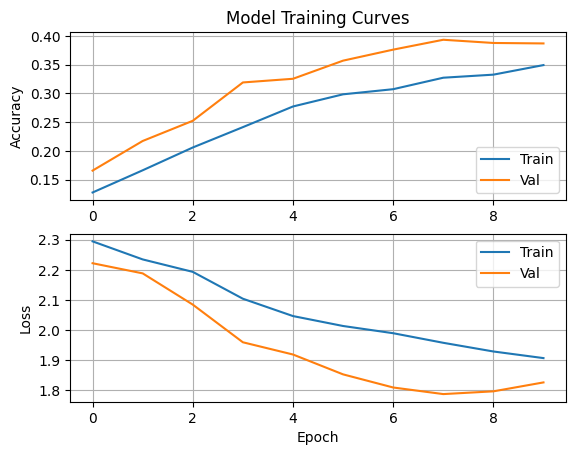

In [49]:
plot_training_curves(history_2)

## 7. Repetir 4, 5 y 6 hasta alcanzar el resultado deseado

>:key: **Nota:** Podriamos seguir iterando sobre el modelo para mejorar el resultado y reducir el sobreajuste. Pero para este ejemplo, vamos a detenernos aquí. En proximos notebooks, veremos como utilizar **Transfer Learning** para mejorar el resultado.

## 8. Hacer Predicciones con el modelo

In [52]:
# Crear una función para preprocesar imágenes externas al dataset
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels).
    """
    # Leer la imagen
    img = tf.io.read_file(filename)
    # Decodificarla en un tensor
    img = tf.image.decode_image(img)
    # Cambiar el tamaño de la imagen
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # Escalar la imagen (valores entre 0 y 1)
    img = img/255.
    return img

In [54]:
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with a model and plots the image with the predicted class as the title.
    """
    # Preprocesar la imagen
    img = load_and_prep_image(filename)
    # Hacer una predicción
    pred = model.predict(tf.expand_dims(img, axis=0))
    # Obtener la clase predicha
    if len(class_names)> 2:
        pred_class = class_names[np.argmax(pred)] # categorical classification
    else:
        pred_class = class_names[int(tf.round(pred))] # binary classification
    # Cargar la imagen
    img = mpimg.imread(filename)
    # Mostrar la imagen y agregar el título
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

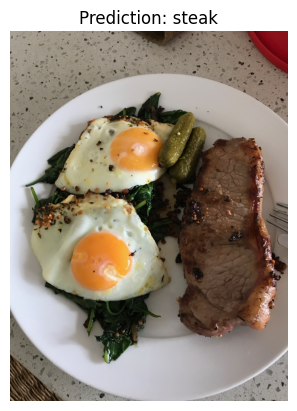

In [55]:
pred_and_plot(model_2, "images/03-steak.jpeg")

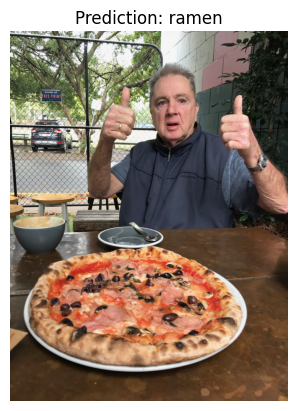

In [56]:
pred_and_plot(model_2, "images/03-pizza-dad.jpeg")

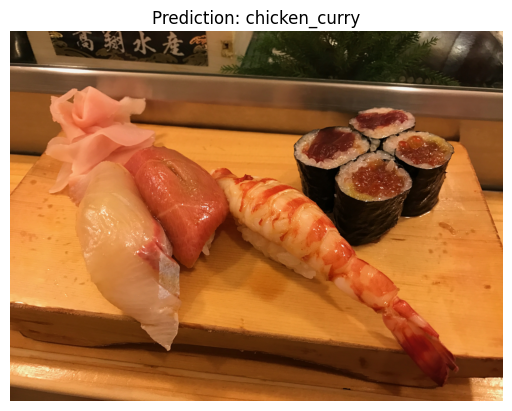

In [57]:
pred_and_plot(model_2, "images/03-sushi.jpeg")

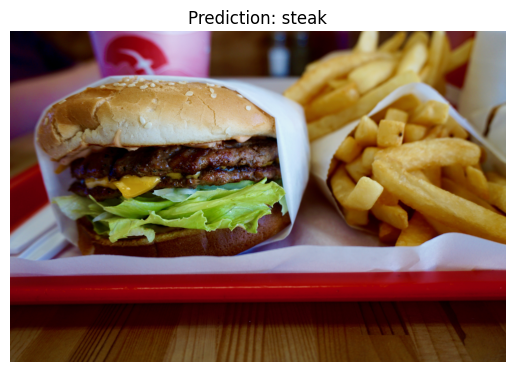

In [58]:
pred_and_plot(model_2, "images/03-hamburger.jpeg")

> :key: **Nota:** En las imagenes de prueba, el modelo tuvo un rendimiento bajo, esto se debe a que el resultado del entrenamiento no fue satisfactorio. En proximos notebooks, veremos como utilizar **Transfer Learning** para mejorar el resultado.

## 9. Salvar y cargar un modelo

In [43]:
# Save a model
model_2.save("cnn_model2")

INFO:tensorflow:Assets written to: cnn_model2\assets


In [44]:
# Load in a model and evaluate it
loaded_model_2 = tf.keras.models.load_model("cnn_model2")
loaded_model_2.evaluate(test_data)

79/79 [==============================] - 22s 277ms/step - loss: 1.7764 - accuracy: 0.4136


[1.776424765586853, 0.41359999775886536]